# Inicjalizacja kontrolera

In [1]:
import can
import matplotlib.pyplot as plt
from matplotlib import interactive
import numpy as np
import os
import time
import math
from IPython.display import display, clear_output
from joint_can import *
%matplotlib widget

In [2]:
def calibrate_joint(cmd,bus,nr_id):
    send_msg(0x1A0 + nr_id, None, bus)
    time.sleep(2)
    send_msg(0x1F0 + nr_id, [1,6], bus)
    send_msg(0x110 + nr_id, [1], bus)
    
    if (send_msg(0x110 + nr_id, None, bus).data[0] == 1):
        send_msg(0x110 + nr_id, [cmd], bus)
        time.sleep(1)
        return True
    else:
        return False
        # print(send_msg(0x010, [3], bus).data[0])
        # time.sleep(5)        

In [3]:
# Ustawienie adresu CAN na "nr_id"

def initialize_joint(bus, mode: int, nr_id):
    send_msg(0x1A0 + nr_id, None, bus)
    time.sleep(1)
    
    send_msg(0x1b0 + nr_id, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x140 + nr_id, None, bus)
    time.sleep(0.1)
    send_msg(0x1a0 + nr_id, None, bus)
    time.sleep(1)
    
    if (send_msg(0x1F0 + nr_id, [mode, 2], bus).data[0] == 1):
        send_msg(0x110 + nr_id, [2], bus)
        time.sleep(1)
        send_msg(0x110 + nr_id, [3], bus).data[0]
        time.sleep(5)
        return True
    else:
        return False
      

In [4]:
# os.popen('/home/pi/mech_diagnostics/can_down.sh')
# time.sleep(1)
# os.popen('/home/pi/mech_diagnostics/can_up.sh')
# time.sleep(1)


In [5]:
bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)

# Parametry kalibracji

In [6]:
nr_id = get_can_id(bus)

In [13]:
# serial="JANUSZ_3_RI70_TESTY" #musi byc min jedna litera w numerze
# note="Janusz 6 - joint 2"  #póki co musi być cokolwiek

In [14]:
# path = "/home/pi/mech_diagnostics/diagnostic_data"
# try: 
#     os.mkdir(path+'/'+serial) 
# except OSError as error: 
#     pass

In [12]:
initialize_joint(bus,2, nr_id)

True

# Kalibracja enkodera absolutnego

In [10]:
# while not calibrate_joint(131,bus,nr_id): # 131 uruchomienie kalibracji enk absolutnego
#     time.sleep(1)
    
# while(get_data_t(send_msg(0x180 + nr_id,None,bus)).FSM != 1):


#     print(f'Calibration in progress\r', end='')
#     time.sleep(1)
# print('                              \r',end='')

# send_msg(0x110 + nr_id, [2], bus)
# time.sleep(0.1)
# send_msg(0x110 + nr_id, [1], bus)
# time.sleep(0.1)
# send_msg(0x140 + nr_id, None, bus)
# time.sleep(1)

# print(f'1/2 Calibration done', end='')

# Kalibracja miejsca zerowego

In [11]:
while not calibrate_joint(161,bus,nr_id): # 161 uruchomienie kalibracji zera
    time.sleep(0.5)
    
while(get_data_t(send_msg(0x180 + nr_id,None,bus)).FSM != 1):


    print(f'Calibration in progress\r', end='')
    time.sleep(1)
print('                              \r',end='')

send_msg(0x110 + nr_id, [2], bus)
time.sleep(0.1)
send_msg(0x110 + nr_id, [1], bus)
time.sleep(0.1)
send_msg(0x140 + nr_id, None, bus)
time.sleep(1)

print(f'2/2 Calibration done', end='')

2/2 Calibration done          

# Ustawienie zera ręcznie

In [8]:
send_msg(0x1A0 + nr_id, None, bus)
## pozycja zpisana w rejestrze 58(zapisana pozycja zerowa jointa)
msg = send_msg(0x120 + nr_id, [0x58, 1], bus)
data = msg.data
print(f"zapisana pozycja zerowa: 0x58 = {data[1]}, {data[2]}")

act_pos = send_msg(0x120 + nr_id, [0xC1, 1], bus)
data_pos = act_pos.data
print(f'aktualna pozycja jointa: 0xC1 = {data_pos[1]}, {data_pos[2]}')

# # 2) zapisanie odczytanej wartości do rejestru 0x58
# print('zapis do 0x58')
# send_msg(0x130 + nr_id, [0x58, 0x01, data_pos[1], data_pos[2]], bus)
# time.sleep(2)
# # 3) zapis fo flasha
# print('Save to flash')
# send_msg(0x140 + nr_id, [], bus)
# time.sleep(2)

zapisana pozycja zerowa: 0x58 = 108, 63
aktualna pozycja jointa: 0xC1 = 108, 63


# Test enkoderów

In [13]:
# do sprawdzenia enkodera nie uruchamiać bloków sekcji 1
send_msg(0x1A0 + nr_id, None, bus)
time.sleep(1)
send_msg(0x1F0 + nr_id, [2,2], bus)
send_msg(0x110 + nr_id, [2], bus)
time.sleep(0.1)
send_msg(0x110 + nr_id, [3], bus)
time.sleep(6)

In [16]:
position_data=[]
speed_data=[]

set_speed(0.1,bus,nr_id)
time.sleep(1)

run_time=20
start_time=time.time()

while((time.time()-start_time)<(run_time)):
    data=set_speed(1,bus,nr_id)
    position_data.append(data.position)
    speed_data.append(data.speed)
set_speed(0,bus, nr_id)

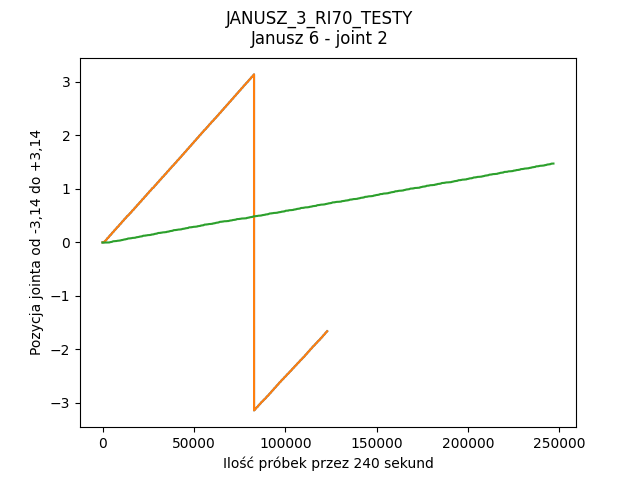

In [18]:
plt.plot(position_data)
# plt.plot(speed_data)
plt.suptitle(serial+ '\n' +note)
plt.xlabel('Ilość próbek przez {} sekund'.format(run_time))
plt.ylabel('Pozycja jointa od -3,14 do +3,14')
plt.show()
plt.savefig(path+'/'+serial+'/enkoder_'+serial+'_'+time.strftime('%y_%m_%d_%H_%M')+'.png', dpi=1200)

# ustawienie na zerze [uruchomić komórki 1.1-1.5]

In [19]:
initialize_joint(bus,2, nr_id)

True

In [17]:
send_msg(0x1A0 + nr_id, None, bus)
time.sleep(1)
send_msg(0x1F0 + nr_id, [2,2], bus)
send_msg(0x110 + nr_id, [2], bus)
time.sleep(1)
send_msg(0x110 + nr_id, [3], bus)
time.sleep(2)


data=set_speed(0,bus,nr_id)
sgn=(int(data.position>0) - int(data.position<0))

data=set_speed(sgn*0.1,bus,nr_id)
print(data.position)
while(abs(data.position)>0.01):
    if (abs(data.position)>0.2):
        data=set_speed(sgn*-0.4,bus,nr_id)
    else:
        data=set_speed(sgn*-0.05,bus,nr_id)
    time.sleep(0.1)

send_msg(0x110 + nr_id, [2], bus)
print(data.position)

0.060402336827904024
0.0065196173084086885


In [ ]:
while True:
    send_msg(0x180 + nr_id, None, bus)
    time.sleep(0.5)
# initialize_joint(bus,2, nr_id)

# Odczytywanie w pętli bierzącej pozycji

In [18]:
# spin = 1
# while (spin < 50):
#     data=set_torque(0,bus,nr_id)
#     # print(f'\r {abs(data.position)}' , end='')
#     print(f'{abs(data.position)}\n' , end='')
#     spin += 1